# **Ultimate Challenge**

In [2]:
import pandas as pd
from pandas import json_normalize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import datetime
import math

import json

%matplotlib inline

pd.set_option('display.max_columns', None)


# Part 1 EDA

The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15 minute time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.


In [10]:
logins = pd.read_json('/content/drive/MyDrive/1631809090_1481053515_ultimate_challenge_3_/ultimate_challenge/logins.json')


In [11]:
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [14]:
logins.shape

(93142, 1)

In [15]:
logins = logins.set_index('login_time') # set index to first column
logins['countFifteenMinute'] = 0
logins = logins.resample('15min').count()
logins.head()

,countFifteenMinute
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [25]:
#logins = logins.reset_index()

In [26]:
logins['dayOfWeek'] = logins['login_time'].dt.day_name()
logins.head()

,login_time,countFifteenMinute,dayOfWeek
0,1970-01-01 20:00:00,2,Thursday
1,1970-01-01 20:15:00,6,Thursday
2,1970-01-01 20:30:00,9,Thursday
3,1970-01-01 20:45:00,7,Thursday
4,1970-01-01 21:00:00,1,Thursday


In [30]:
df_dayweek = logins.groupby('dayOfWeek', as_index=False)['countFifteenMinute'].sum()
df_dayweek

,dayOfWeek,countFifteenMinute
0,Friday,15208
1,Monday,8823
2,Saturday,19377
3,Sunday,18167
4,Thursday,11960
5,Tuesday,9268
6,Wednesday,10339


Text(0.5, 1.0, 'Logins by Day of Week')

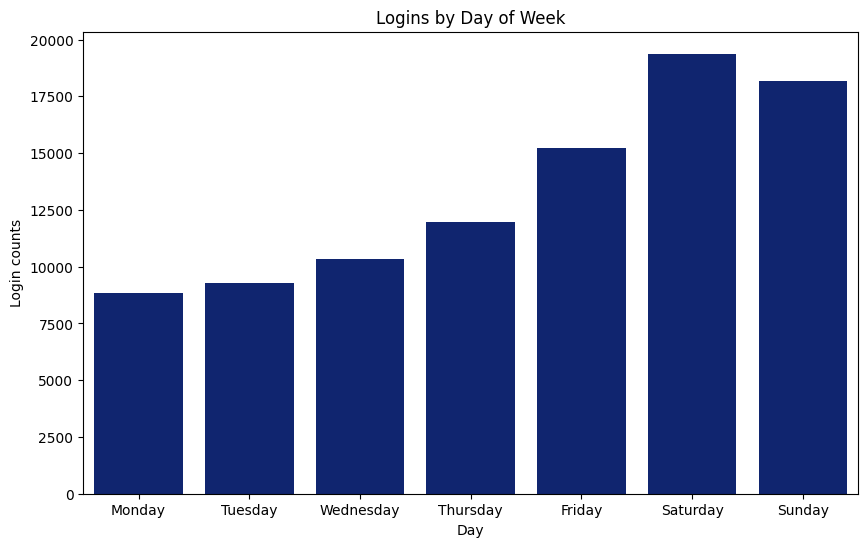

In [32]:
plt.style.use('seaborn-v0_8-dark-palette')
fig = plt.figure(figsize=(10,6))
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# bar plot
sns.barplot(x = 'dayOfWeek', y = 'countFifteenMinute', data = df_dayweek, order=weekday_order)
plt.xlabel('Day')
plt.ylabel('Login counts')
plt.title('Logins by Day of Week')

In [33]:
logins['hour'] = logins['login_time'].dt.hour
logins.head()

,login_time,countFifteenMinute,dayOfWeek,hour
0,1970-01-01 20:00:00,2,Thursday,20
1,1970-01-01 20:15:00,6,Thursday,20
2,1970-01-01 20:30:00,9,Thursday,20
3,1970-01-01 20:45:00,7,Thursday,20
4,1970-01-01 21:00:00,1,Thursday,21


In [36]:
df_hour = logins.groupby('hour', as_index=False)['countFifteenMinute'].sum()
df_hour.head()

,hour,countFifteenMinute
0,0,5993
1,1,6317
2,2,5800
3,3,4831
4,4,5034


Text(0.5, 1.0, 'Logins by Hour')

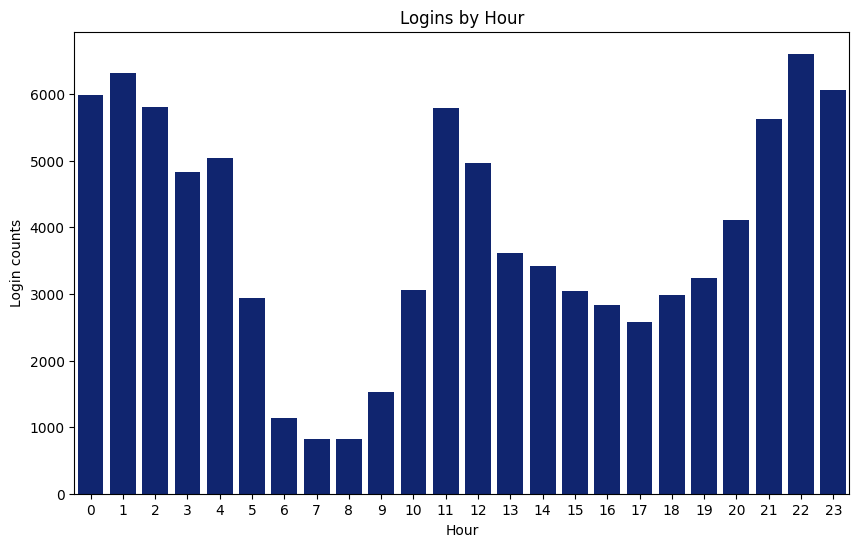

In [37]:
fig = plt.figure(figsize=(10,6))
# bar plot
sns.barplot(x = 'hour', y = 'countFifteenMinute', data = df_hour)
plt.xlabel('Hour')
plt.ylabel('Login counts')
plt.title('Logins by Hour')

In [40]:
df_day_hour = logins.groupby(['dayOfWeek','hour'], as_index=False)['countFifteenMinute'].sum()
df_day_hour.head()

,dayOfWeek,hour,countFifteenMinute
0,Friday,0,975
1,Friday,1,957
2,Friday,2,771
3,Friday,3,502
4,Friday,4,353


<Figure size 2800x1400 with 0 Axes>

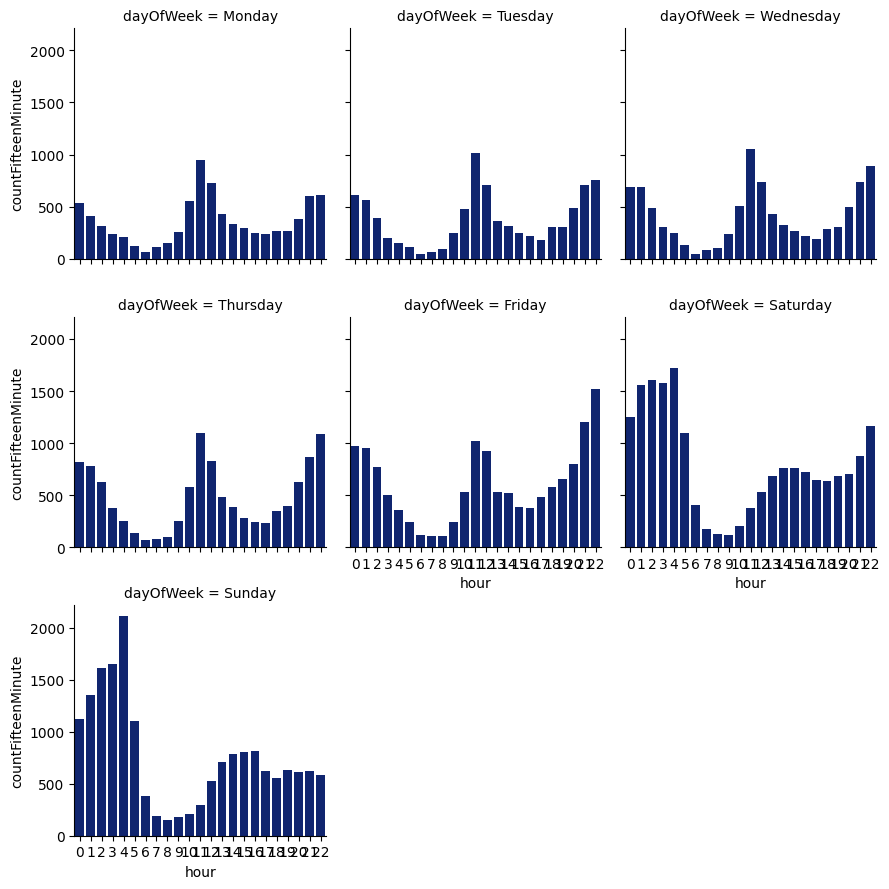

In [41]:
fig = plt.figure(figsize=(28,14))
temp = sns.FacetGrid(df_day_hour, col="dayOfWeek", col_wrap=3, col_order=weekday_order)
temp.map(sns.barplot, "hour", "countFifteenMinute", order=range(0,23))

So, we have it grouped by the hour for each day of the week. If we examine the plots, we can observe a peak in logins at night. Within the range of 2100-200.. This details a pattern of users logging in mostly at night on weekends.

# Part 2 Experiment and Metrics Design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.

1) What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?

2) Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:

a) how you will implement the experiment

b) what statistical test(s) you will conduct to verify the significance of the
observation

c) how you would interpret the results and provide recommendations to the city
operations team along with any caveats


**We need to test the hypothesis that reimbursing toll costs will encourage drivers to use driver services in both cities.**

**Revenue is determined by the cost of services subtracted from sales. We must observe metrics like wait time, immediately available drivers, and number of trips for determining correlations.**

**To test this hypothesis, we can divide into two groups of drivers, one with toll fees credited and one without. This would easily support A/B testing where the null hypothesis supports the conclusion that toll free reimbursments don't impact revenue.**

**If there is a positive relationship between revenue and toll fee reimbursments, we would recommend to reimburse. If there is a negative correlation, don't reimburse.**

# Part 3 Predictive Modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention.

**Data Description**

1. city: city this user signed up in
2. phone: primary device for this user
3. signup_date: date of account registration; in the form ‘YYYY MM DD’
4. last_trip_date: the last time this user completed a trip; in the form ‘YYYY MM DD’
5. avg_dist: the average distance in miles per trip taken in the first 30 days after signup
6. avg_rating_by_driver: the rider’s average rating over all of their trips
7. avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
8. surge_pct: the percent of trips taken with surge multiplier > 1
9. avg_surge: The average surge multiplier over all of this user’s trips
10. trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
11. ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
12. weekday_pct: the percent of the user’s trips occurring during a weekday

# **1. Data Wrangling**

In [3]:
with open('/content/drive/MyDrive/1631809090_1481053515_ultimate_challenge_3_/ultimate_challenge/ultimate_data_challenge.json') as f:
    data = json.load(f)

df = pd.DataFrame(data)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [4]:
df.shape

(50000, 12)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [7]:
df[df['avg_rating_by_driver'].isnull()].count()

,0
city,201
trips_in_first_30_days,201
signup_date,201
avg_rating_of_driver,134
avg_surge,201
last_trip_date,201
phone,198
surge_pct,201
ultimate_black_user,201
weekday_pct,201


In [8]:
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean())
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].round(1)

df['avg_rating_by_driver'] = df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean())
df['avg_rating_by_driver'] = df['avg_rating_by_driver'].round(1)

In [9]:
df['phone'] = df['phone'].fillna(df['phone'].mode().iloc[0])

In [10]:
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] =  pd.to_datetime(df['last_trip_date'])

In [11]:
earliest_signup = df.signup_date.min()
latest_signup = df.signup_date.max()
signups_ct = df.signup_date.count()
last_trip = df.last_trip_date.max()

print('There were {} signups between {} and {}'.format(signups_ct, earliest_signup, latest_signup))
print('Last trip: {}'.format(last_trip))

There were 50000 signups between 2014-01-01 00:00:00 and 2014-01-31 00:00:00
Last trip: 2014-07-01 00:00:00


Active users are defined as users with a trip within the 6th month.

Retention users are defined as users with a trip within the last 30 days.

In [12]:
from datetime import date
from dateutil.relativedelta import relativedelta

last_log_date = df['last_trip_date'].dt.date
print("Last log date: {}".format(last_log_date.max()))

retention_users = df['last_trip_date'].dt.date >= (last_log_date.max() - relativedelta(days=+30))

df_retention_users = df.iloc[np.nonzero(retention_users)]
print("num of retention users: {}".format(df_retention_users.shape[0]))
df['retained'] = retention_users

Last log date: 2014-07-01
num of retention users: 18804


In [13]:
df['active'] = [True if x.month >= 6 else False for x in df.last_trip_date]

There both the same.

In [14]:
df = df.drop('active', axis=1)

In [16]:
categorical_feature_mask = df.dtypes == object
categorical_cols = df.columns[categorical_feature_mask].tolist()
categorical_cols

['city', 'phone']

In [18]:
int_feature_mask = df.dtypes == int
int_cols = df.columns[int_feature_mask].tolist()
int_cols

['trips_in_first_30_days']

In [20]:
numeric_feature_mask = df.dtypes == np.number
numeric_cols = df.columns[numeric_feature_mask].tolist()
comb_numeric_cols = numeric_cols + int_cols
comb_numeric_cols

['avg_rating_of_driver',
 'avg_surge',
 'surge_pct',
 'weekday_pct',
 'avg_dist',
 'avg_rating_by_driver',
 'trips_in_first_30_days']

In [21]:
bool_feature_mask = df.dtypes == bool
bool_cols = df.columns[bool_feature_mask].tolist()
bool_cols

['ultimate_black_user', 'retained']

In [22]:
time_cols = ['last_trip_date', 'signup_date']
df = df.drop(time_cols, axis=1)

In [23]:
def boolToint(x):
    if(x==True):
        return 1
    elif(x==False):
        return 0
    return "error"

for b in bool_cols:
    df[b] = df[b].apply(boolToint)

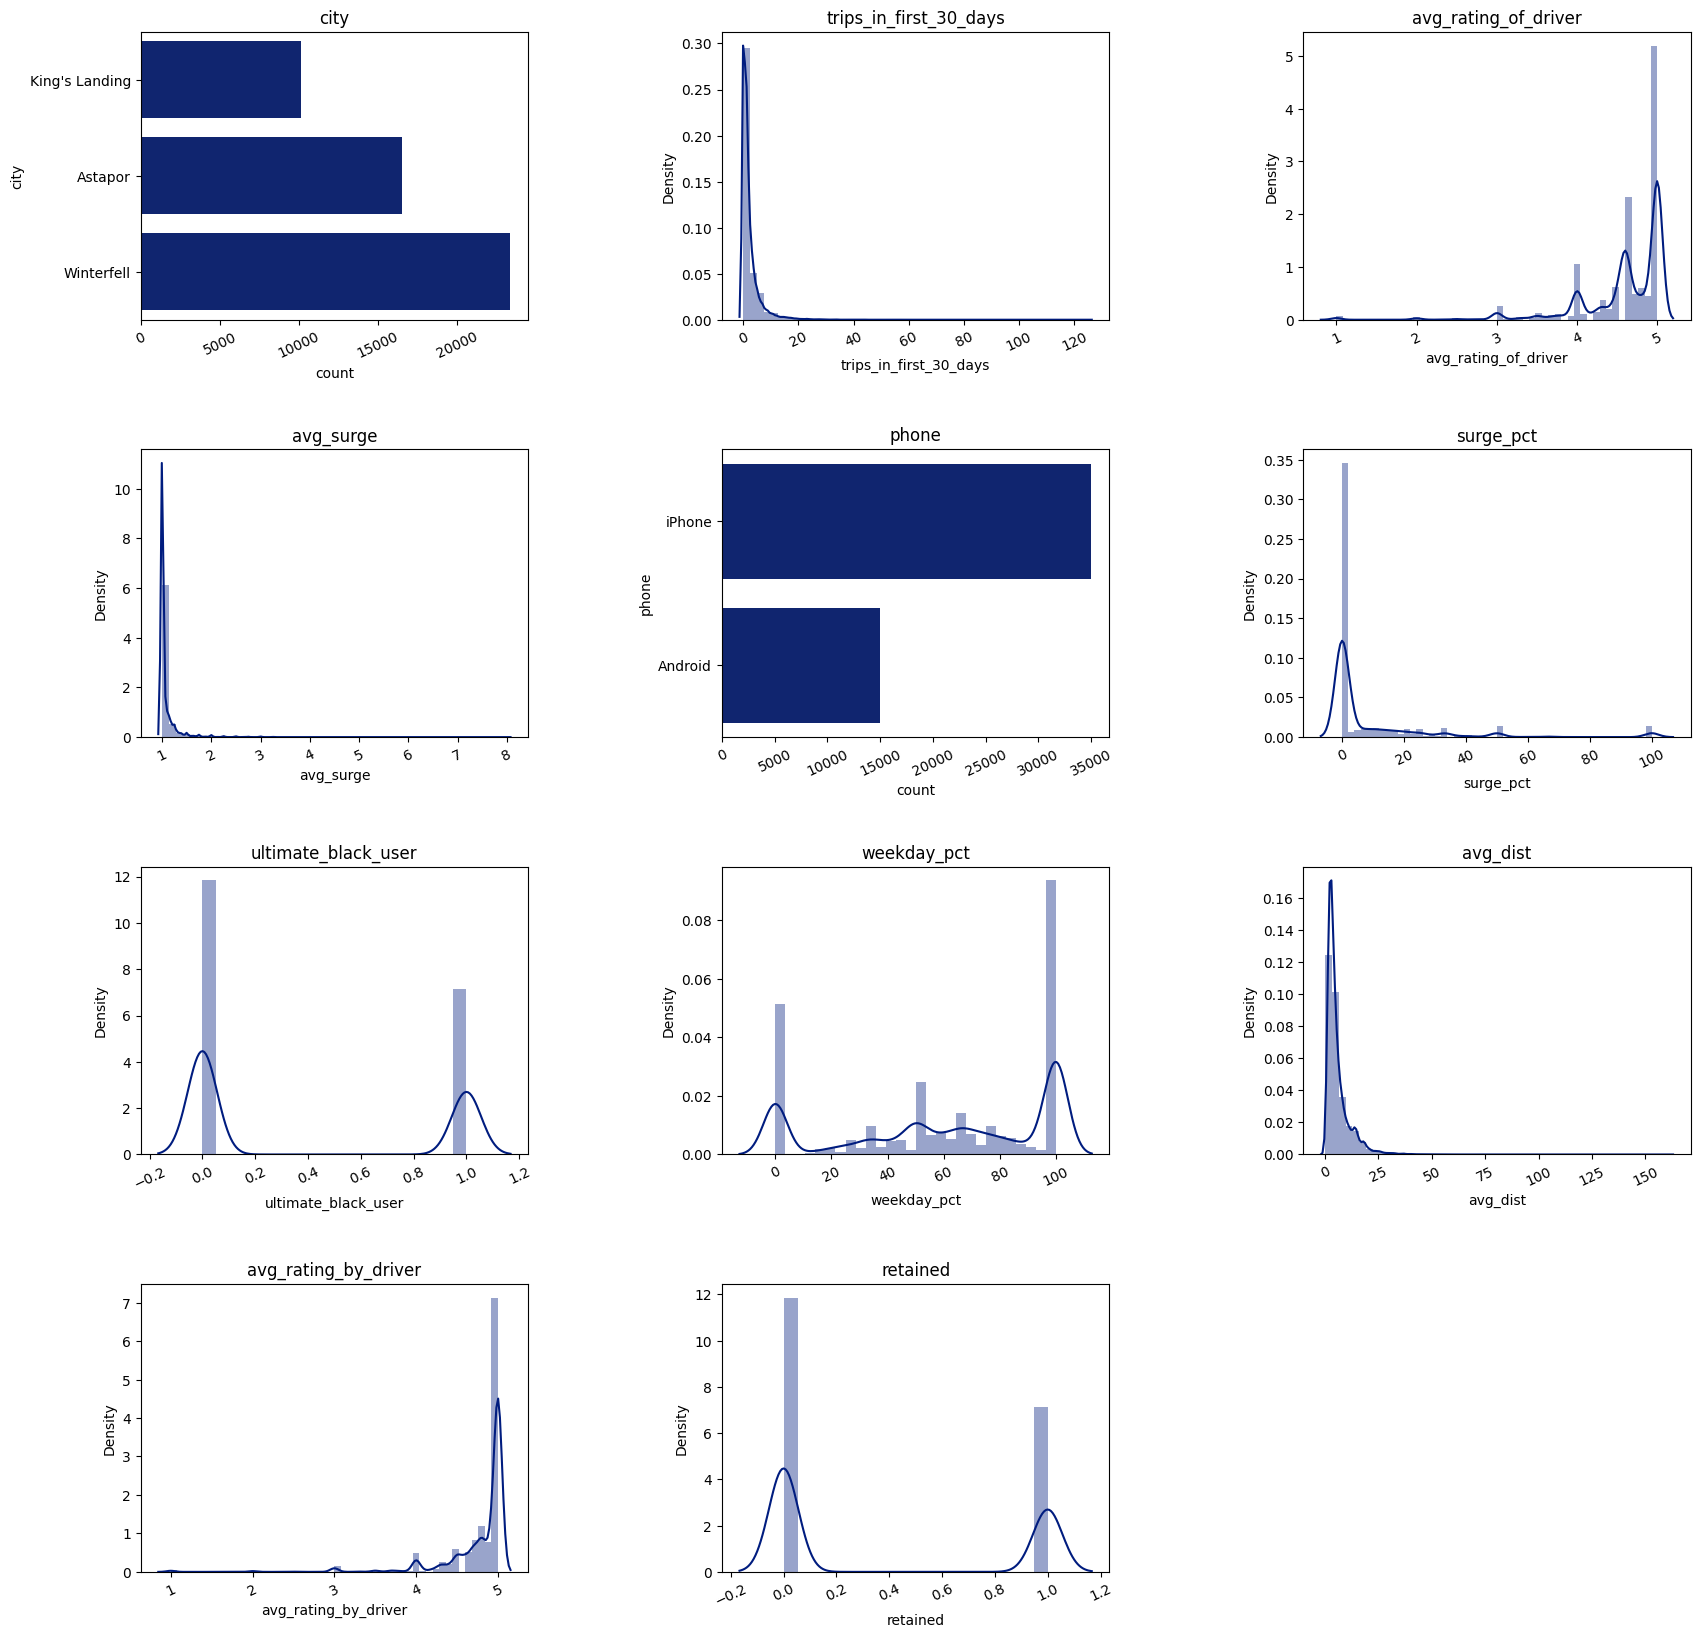

In [24]:
def plot_distribution(dataset, cols=5, width=20, height=15, hspace=0.2, wspace=0.5):
    plt.style.use('seaborn-v0_8-dark-palette')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if dataset.dtypes[column] == object:
            g = sns.countplot(y=column, data=dataset)
            substrings = [s.get_text()[:18] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)
            plt.xticks(rotation=25)
        else:
            g = sns.distplot(dataset[column])
            plt.xticks(rotation=25)

plot_distribution(df, cols=3, width=20, height=20, hspace=0.45, wspace=0.5)

Some observations can be made. One, the number of retained Apple users exceed the number of Android users. King's Landing has more retained users.

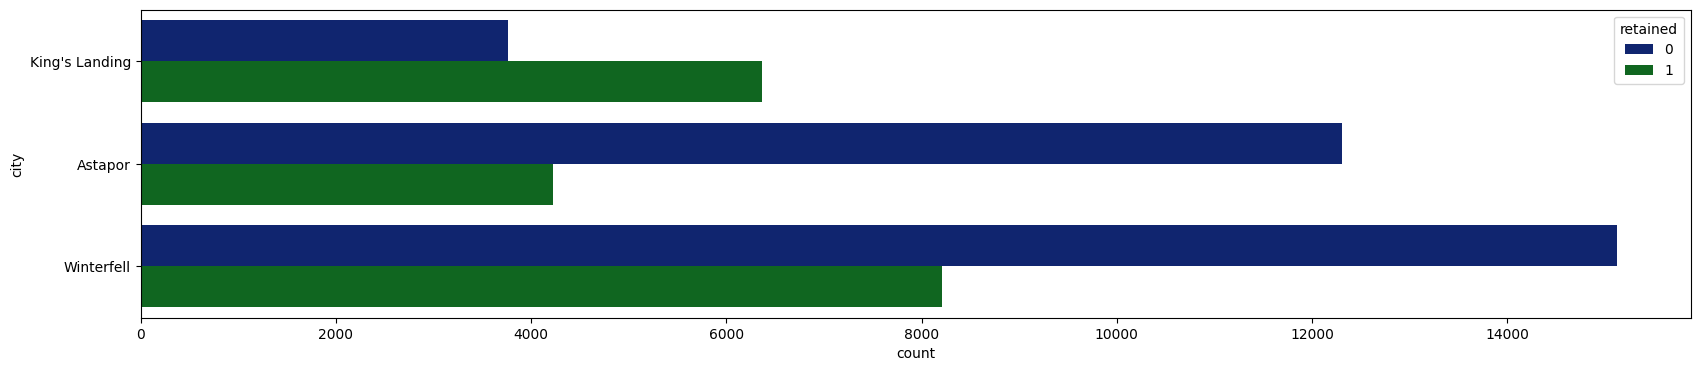

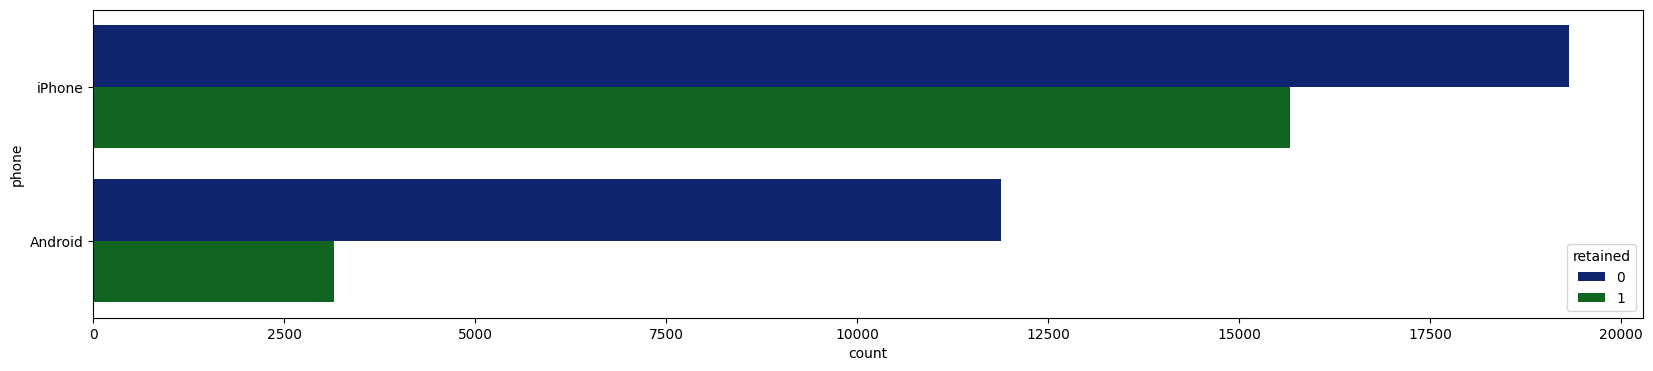

In [25]:
plt.style.use('seaborn-v0_8-dark-palette')

for cat in categorical_cols:
    fig = plt.figure(figsize=(20,4))
    sns.countplot(y=cat, hue="retained", data=df)

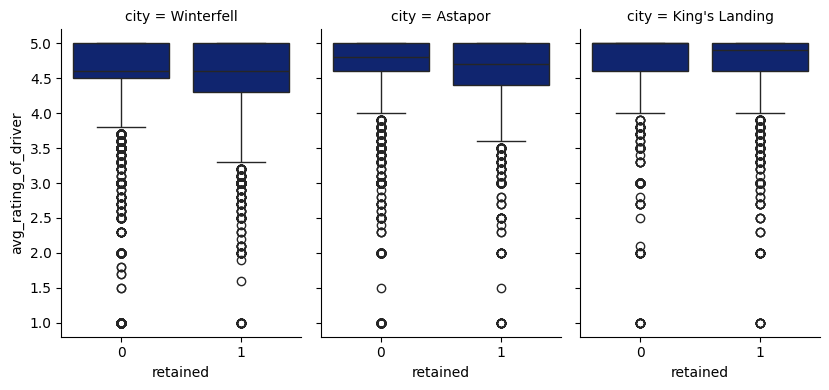

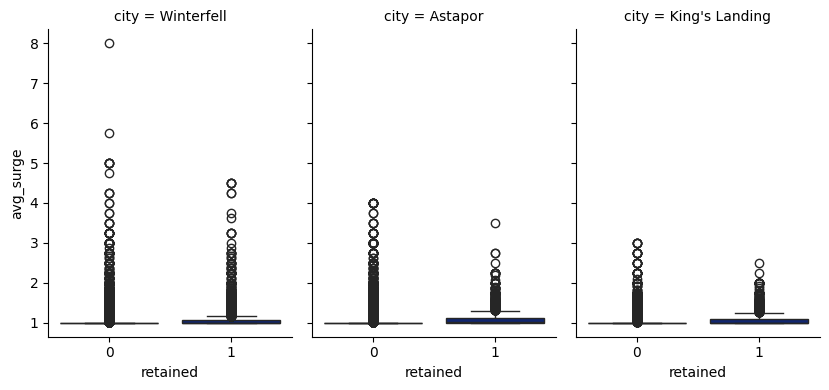

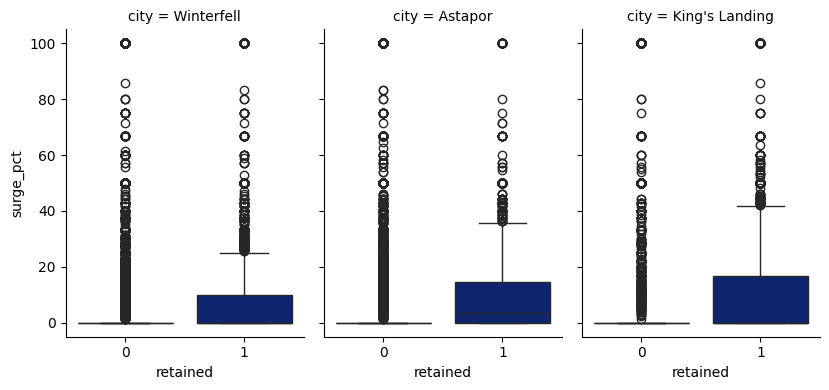

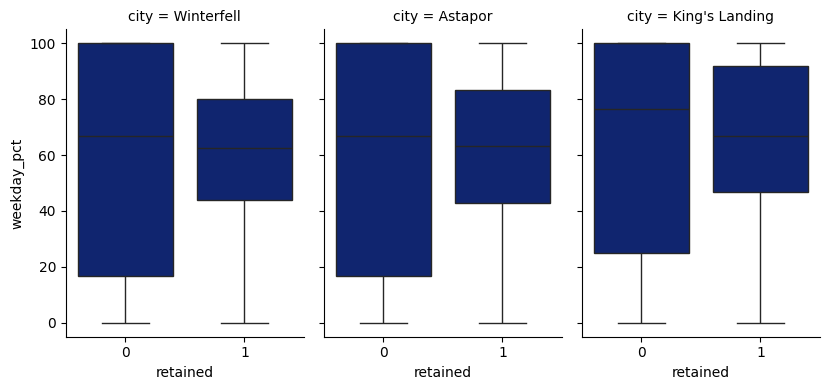

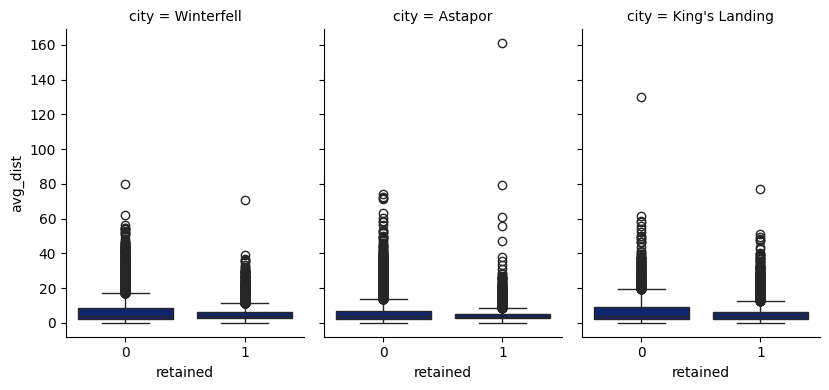

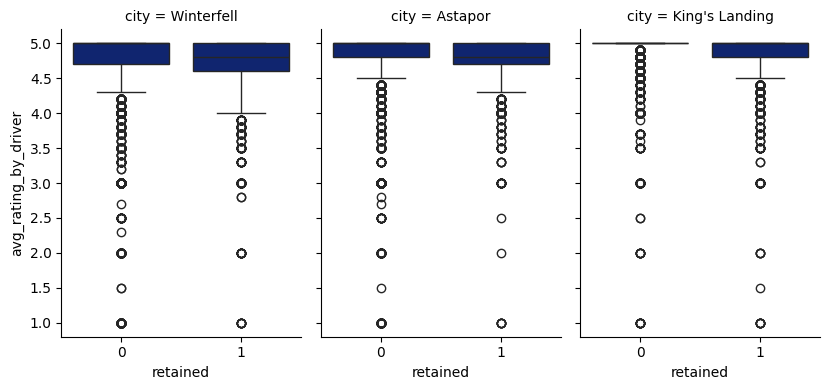

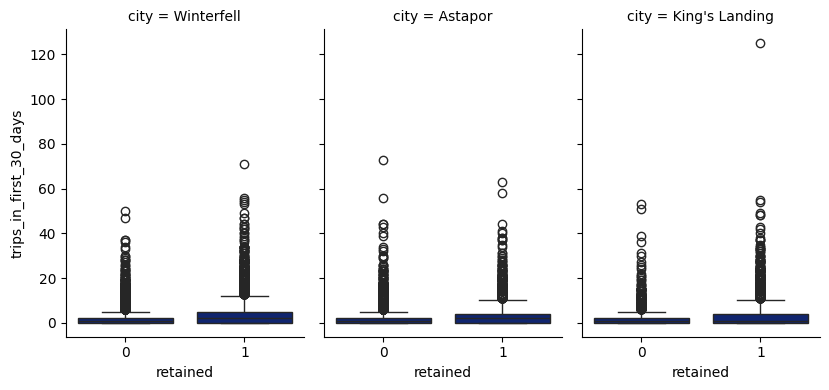

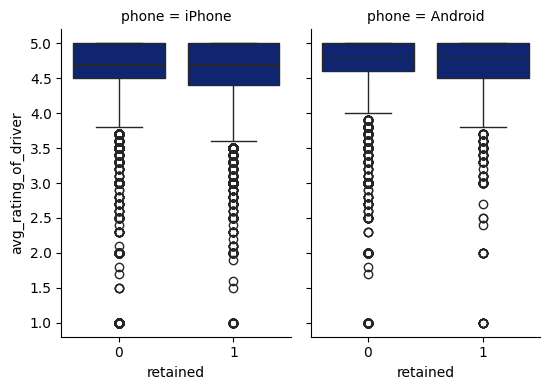

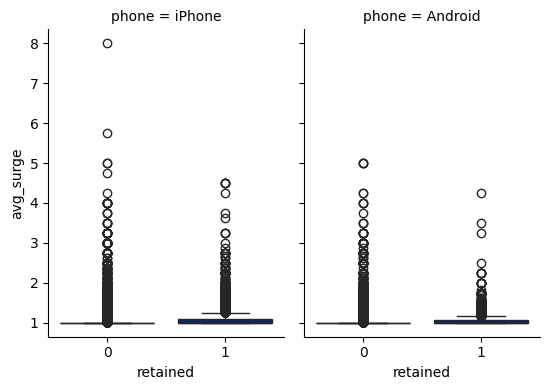

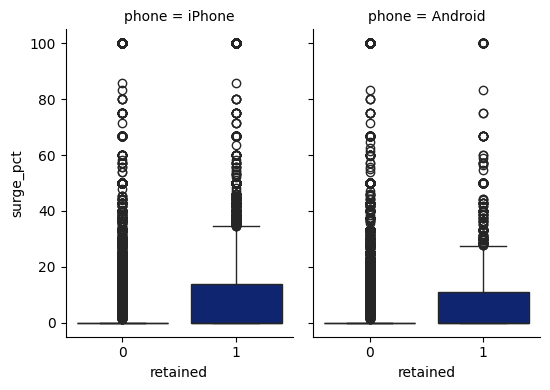

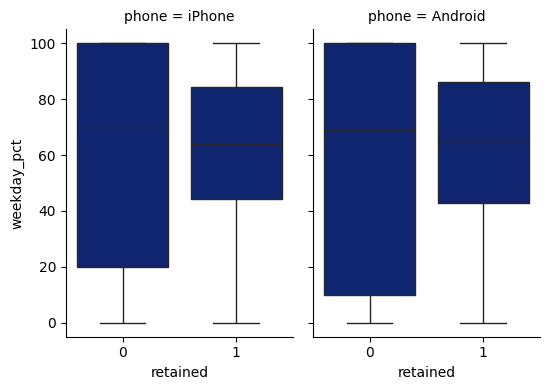

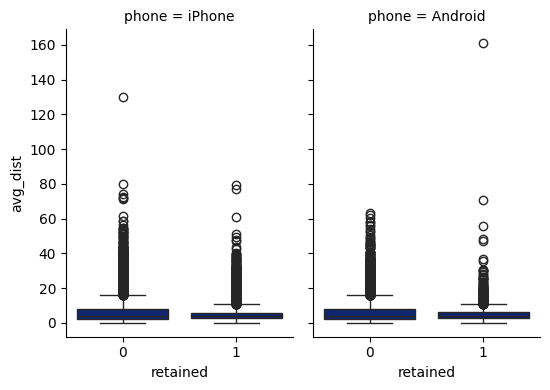

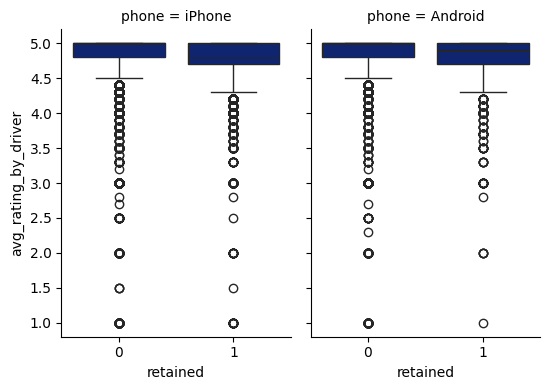

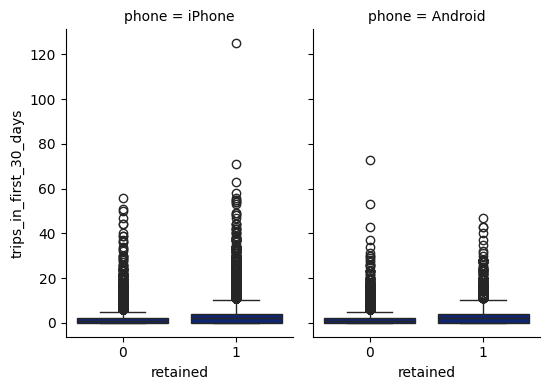

In [26]:
for cat in categorical_cols:
    for num in comb_numeric_cols:
        g = sns.FacetGrid(df, col=cat,height=4, aspect=.7,
                          col_order=df[cat].value_counts().index, row_order=num)
        g = g.map(sns.boxplot, 'retained', num)

In [27]:
y = df['retained']
X = df.drop('retained', axis=1)

In [28]:
print("Number of y: {}".format(len(y)))
df.info()

Number of y: 50000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   avg_rating_of_driver    50000 non-null  float64
 3   avg_surge               50000 non-null  float64
 4   phone                   50000 non-null  object 
 5   surge_pct               50000 non-null  float64
 6   ultimate_black_user     50000 non-null  int64  
 7   weekday_pct             50000 non-null  float64
 8   avg_dist                50000 non-null  float64
 9   avg_rating_by_driver    50000 non-null  float64
 10  retained                50000 non-null  int64  
dtypes: float64(6), int64(3), object(2)
memory usage: 4.2+ MB


In [29]:
X_encoded_getdummies = pd.get_dummies(X, columns = categorical_cols, prefix_sep='_', drop_first=True)

In [30]:
X = X_encoded_getdummies
X.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,city_King's Landing,city_Winterfell,phone_iPhone
0,4,4.7,1.10,15.4,1,46.2,3.67,5.0,True,False,True
1,0,5.0,1.00,0.0,0,50.0,8.26,5.0,False,False,False
2,3,4.3,1.00,0.0,0,100.0,0.77,5.0,False,False,True
3,9,4.6,1.14,20.0,1,80.0,2.36,4.9,True,False,True
4,14,4.4,1.19,11.8,0,82.4,3.13,4.9,False,True,False


<Axes: >

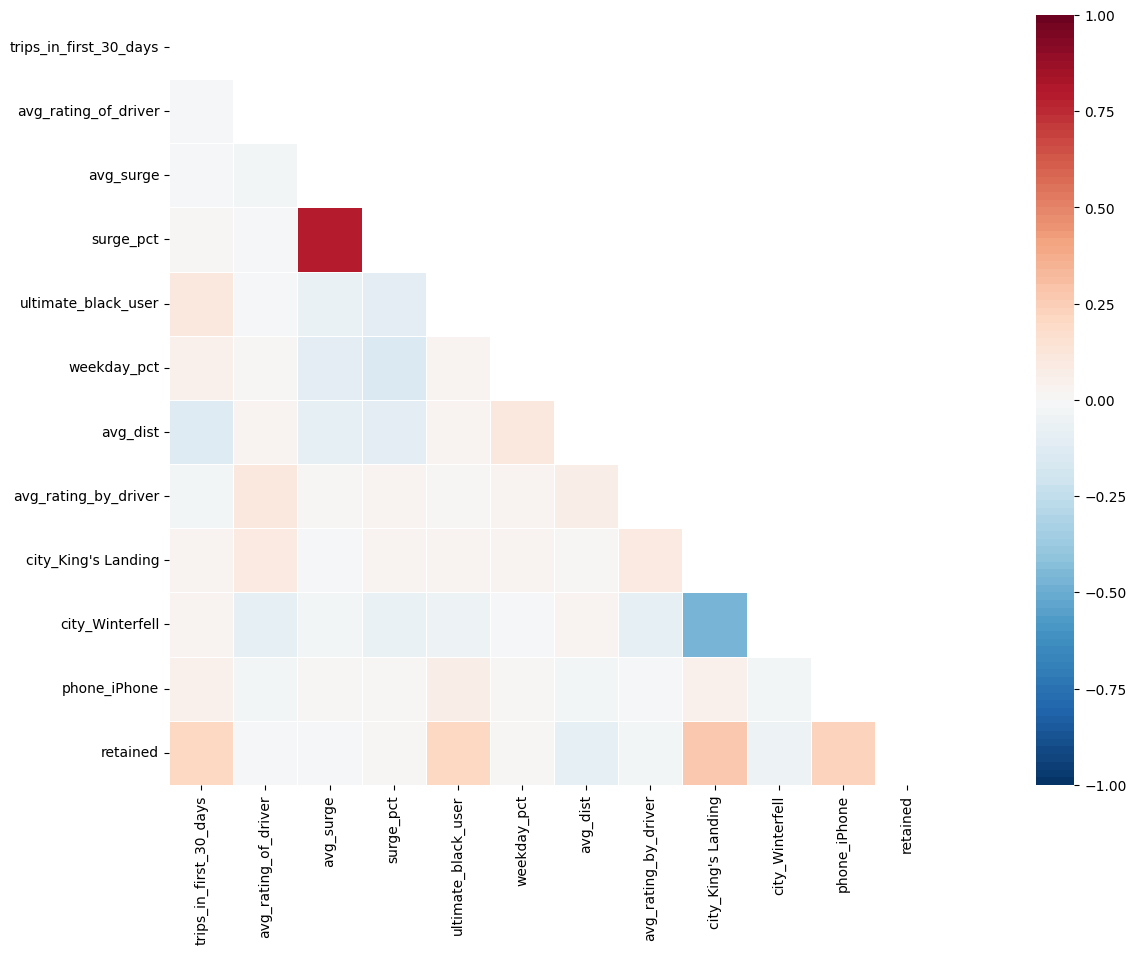

In [32]:
corr_Xy = pd.concat([X,y], axis=1)

plt.style.use('seaborn-v0_8-dark-palette')
fig = plt.figure(figsize=(25,10))

mask = np.zeros_like(corr_Xy.corr(), dtype = bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_Xy.corr(),
            vmin=-1, vmax=1,
            square=True,
            cmap=sns.color_palette("RdBu_r", 100),
            mask=mask,
            linewidths=.5)

Feature ranking:
1. feature 6 (0.31)
2. feature 5 (0.13)
3. feature 7 (0.12)
4. feature 3 (0.08)
5. feature 1 (0.08)
6. feature 0 (0.08)
7. feature 2 (0.06)
8. feature 8 (0.06)
9. feature 10 (0.03)
10. feature 4 (0.03)
11. feature 9 (0.01)


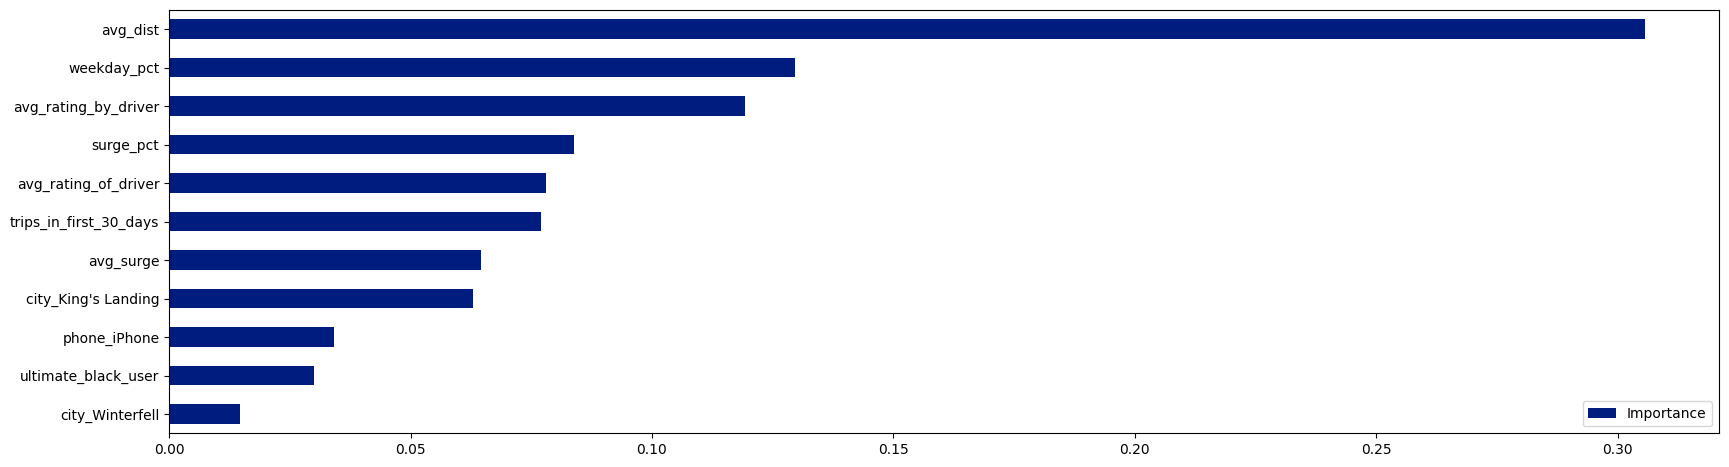

In [34]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X, y)

plt.style.use('seaborn-v0_8-dark-palette')
importances = rf.feature_importances_

#####
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%.2f)" % (f + 1, indices[f], importances[indices[f]]))

#####
df_importances = pd.DataFrame(importances, index=X.columns, columns=["Importance"])
df_importances.sort_values(by='Importance', ascending=True).plot(kind='barh', figsize=(20,len(importances)/2));

Top features impacting retention are **average distance, percentage of trips on the weekdays, and average rating by driver.**

In [35]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
SEED = 23

In [36]:
df_copy = df.copy()

In [37]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
df_copy[comb_numeric_cols] = scaler.fit_transform(df_copy[comb_numeric_cols])

df_copy.head()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,0.453984,0.174689,0.113506,iPhone,0.328202,1,-0.397131,-0.372650,0.497484,1
1,Astapor,-0.600689,0.705689,-0.336268,Android,-0.443394,0,-0.294653,0.431583,0.497484,0
2,Astapor,0.190316,-0.533312,-0.336268,iPhone,-0.443394,0,1.053741,-0.880771,0.497484,0
3,King's Landing,1.772325,-0.002312,0.293416,iPhone,0.558679,1,0.514383,-0.602181,0.273144,1
4,Winterfell,3.090665,-0.356312,0.518303,Android,0.147829,0,0.579106,-0.467266,0.273144,0


In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3, random_state = SEED)

train_total = len(y_train)
print('Training Set\nTotal:\t\t{}'.format(train_total))
test_total = len(y_test)
print('Test Set\nTotal:\t\t{}'.format(test_total))

Training Set
Total:		35000
Test Set
Total:		15000


Class 0: 31196
Class 1: 18804
Proportion: 2 : 1


<Axes: title={'center': 'Count (target)'}, xlabel='retained'>

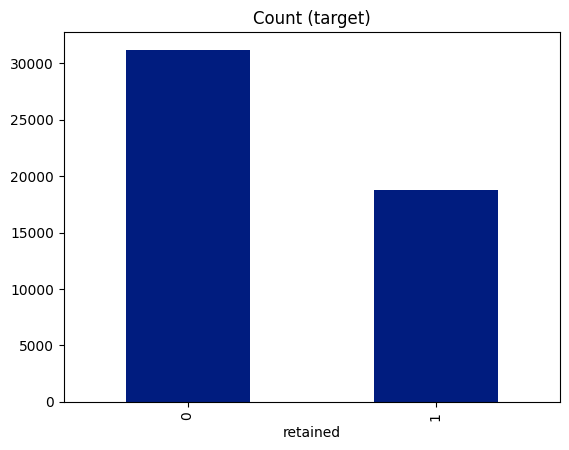

In [39]:
target_count = df.retained.value_counts()
print('Class 0: {}'.format(target_count[0]))
print('Class 1: {}'.format(target_count[1]))
print('Proportion: {}'.format(round(target_count[0] / target_count[1]), 2), ': 1')

target_count.plot(kind='bar', title = 'Count (target)')

In [40]:
# Machine learning
from sklearn import datasets, model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, SGDClassifier

#tree
import graphviz
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

# Grid and Random Search
import scipy.stats as st
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Metrics
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc

import time
import datetime

In [41]:
def plot_roc_curve(y_test, preds):
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [42]:
def fit_ml_algo(algo, X_train, y_train, X_test, y_test, cv):
    # One Pass
    model = algo.fit(X_train, y_train)
    test_pred = model.predict(X_test)
    if (isinstance(algo, (LogisticRegression,
                          KNeighborsClassifier,
                          GaussianNB,
                          DecisionTreeClassifier,
                          RandomForestClassifier,
                          GradientBoostingClassifier))):
        probs = model.predict_proba(X_test)[:,1]
    else:
        probs = "Not Available"
    acc = round(model.score(X_test, y_test) * 100, 2)
    # CV
    train_pred = model_selection.cross_val_predict(algo,
                                                  X_train,
                                                  y_train,
                                                  cv=cv,
                                                  n_jobs = -1)
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    return train_pred, test_pred, acc, acc_cv, probs

In [43]:
# Logistic Regression - Random Search for Hyperparameters

# Utility function to report best scores
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# Specify parameters and distributions to sample from
param_dist = {'penalty': ['l2', 'l1'],
                         'class_weight': [None, 'balanced'],
                         'C': np.logspace(-20, 20, 10000),
                         'intercept_scaling': np.logspace(-20, 20, 10000)}

# Run Randomized Search
n_iter_search = 10
lrc = LogisticRegression()
random_search = RandomizedSearchCV(lrc,
                                   n_jobs=-1,
                                   param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time.time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 8.47 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.703 (std: 0.002)
Parameters: {'penalty': 'l2', 'intercept_scaling': 202829309919.96997, 'class_weight': 'balanced', 'C': 4.4459522751891276e+19}

Model with rank: 2
Mean validation score: 0.623 (std: 0.000)
Parameters: {'penalty': 'l2', 'intercept_scaling': 60726512130614.19, 'class_weight': None, 'C': 5.663374845755559e-10}

Model with rank: 3
Mean validation score: 0.548 (std: 0.008)
Parameters: {'penalty': 'l2', 'intercept_scaling': 3.6387824850747874e-11, 'class_weight': 'balanced', 'C': 7.540284610638354e-07}

Model with rank: 4
Mean validation score: nan (std: nan)
Parameters: {'penalty': 'l1', 'intercept_scaling': 4825789307662169.0, 'class_weight': 'balanced', 'C': 2.660985476781508e-10}

Model with rank: 4
Mean validation score: nan (std: nan)
Parameters: {'penalty': 'l1', 'intercept_scaling': 0.5888124682223844, 'class_weight': None, 'C': 1.0195319497075261e-

In [44]:
start_time = time.time()
train_pred_log, test_pred_log, acc_log, acc_cv_log, probs_log = fit_ml_algo(LogisticRegression(n_jobs = -1),
                                                                 X_train,
                                                                 y_train,
                                                                 X_test, y_test,
                                                                 10)
log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

Accuracy: 71.74
Accuracy CV 10-Fold: 71.82
Running Time: 0:00:06.902487


In [45]:
print(metrics.classification_report(y_train, train_pred_log))

              precision    recall  f1-score   support

           0       0.74      0.85      0.79     21805
           1       0.67      0.50      0.57     13195

    accuracy                           0.72     35000
   macro avg       0.70      0.67      0.68     35000
weighted avg       0.71      0.72      0.71     35000



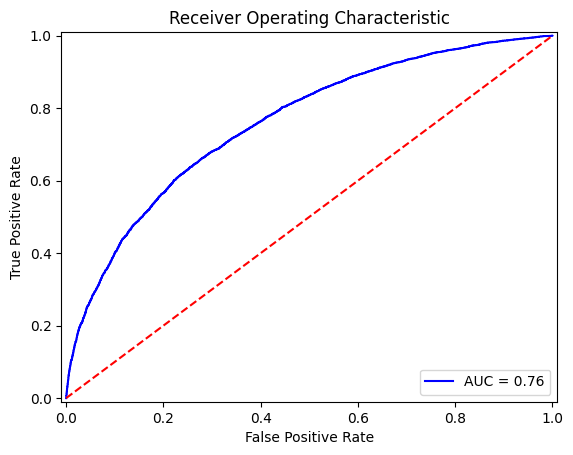

In [46]:
plot_roc_curve(y_test, probs_log)

In [47]:
# k-Nearest Neighbors
start_time = time.time()
train_pred_knn, test_pred_knn, acc_knn, acc_cv_knn, probs_knn = fit_ml_algo(KNeighborsClassifier(n_neighbors = 3,
                                                                                                 n_jobs = -1),
                                                                                                 X_train,
                                                                                                 y_train,
                                                                                                 X_test, y_test,
                                                                                                 10)
knn_time = (time.time() - start_time)
print("Accuracy: %s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)
print("Running Time: %s" % datetime.timedelta(seconds=knn_time))

Accuracy: 73.05
Accuracy CV 10-Fold: 72.83
Running Time: 0:00:11.176718


In [48]:
print(metrics.classification_report(y_train, train_pred_knn))

              precision    recall  f1-score   support

           0       0.77      0.80      0.79     21805
           1       0.65      0.61      0.63     13195

    accuracy                           0.73     35000
   macro avg       0.71      0.70      0.71     35000
weighted avg       0.73      0.73      0.73     35000



In [49]:
print(metrics.classification_report(y_test, test_pred_knn))

              precision    recall  f1-score   support

           0       0.78      0.80      0.79      9391
           1       0.65      0.62      0.63      5609

    accuracy                           0.73     15000
   macro avg       0.71      0.71      0.71     15000
weighted avg       0.73      0.73      0.73     15000



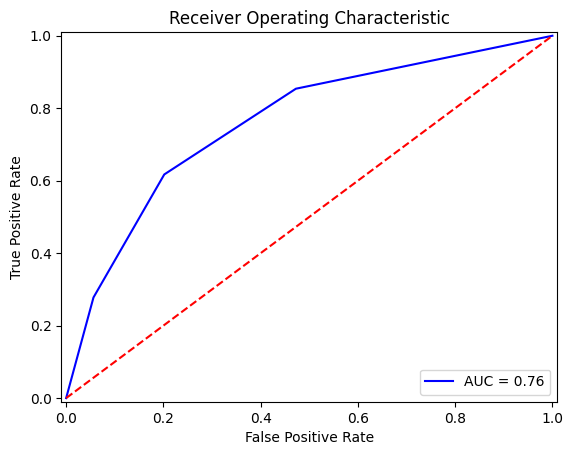

In [50]:
plot_roc_curve(y_test, probs_knn)

In [51]:
tart_time = time.time()

def fit_ml_algo_clf(algo, X_train, y_train, X_test, y_test, cv):
    # One Pass
    model = algo.fit(X_train, y_train)
    test_pred = model.predict(X_test)
    if (isinstance(algo, (LogisticRegression,
                          KNeighborsClassifier,
                          GaussianNB,
                          DecisionTreeClassifier,
                          RandomForestClassifier,
                          GradientBoostingClassifier))):
        probs = model.predict_proba(X_test)[:,1]
    else:
        probs = "Not Available"
    acc = round(model.score(X_test, y_test) * 100, 2)
    # CV
    train_pred = model_selection.cross_val_predict(algo,
                                                  X_train,
                                                  y_train,
                                                  cv=cv,
                                                  n_jobs = -1)
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    return train_pred, test_pred, acc, acc_cv, probs, model

train_pred_dt, test_pred_dt, acc_dt, acc_cv_dt, probs_dt, clf_obj = fit_ml_algo_clf(DecisionTreeClassifier(),
                                                             X_train,
                                                             y_train,
                                                             X_test, y_test,
                                                             10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))

Accuracy: 70.41
Accuracy CV 10-Fold: 70.24
Running Time: 0:01:09.086402


In [52]:
print(metrics.classification_report(y_train, train_pred_dt))

              precision    recall  f1-score   support

           0       0.76      0.76      0.76     21805
           1       0.61      0.60      0.60     13195

    accuracy                           0.70     35000
   macro avg       0.68      0.68      0.68     35000
weighted avg       0.70      0.70      0.70     35000



In [53]:
print(metrics.classification_report(y_test, test_pred_dt))

              precision    recall  f1-score   support

           0       0.77      0.76      0.76      9391
           1       0.60      0.61      0.61      5609

    accuracy                           0.70     15000
   macro avg       0.68      0.69      0.68     15000
weighted avg       0.70      0.70      0.70     15000



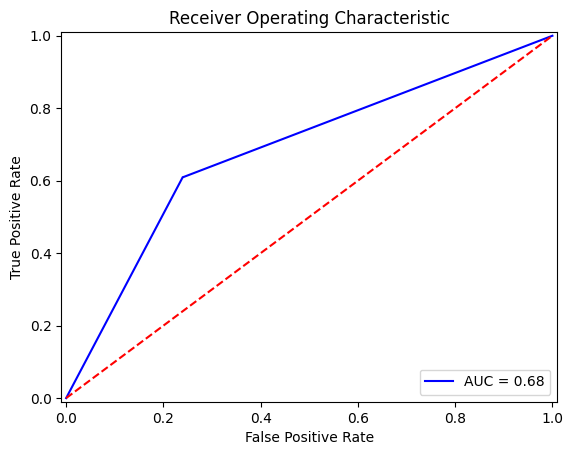

In [54]:
plot_roc_curve(y_test, probs_dt)

In [55]:
# Random Forest Classifier - Random Search for Hyperparameters

# Utility function to report best scores
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# Specify parameters and distributions to sample from
param_dist = {"max_depth": [10, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 20),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# Run Randomized Search
n_iter_search = 10
rfc = RandomForestClassifier(n_estimators=10)
random_search = RandomizedSearchCV(rfc,
                                   n_jobs = -1,
                                   param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time.time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 22.27 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.781 (std: 0.004)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 3, 'min_samples_leaf': 8, 'min_samples_split': 2}

Model with rank: 2
Mean validation score: 0.780 (std: 0.005)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'max_features': 4, 'min_samples_leaf': 2, 'min_samples_split': 12}

Model with rank: 3
Mean validation score: 0.779 (std: 0.003)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 9, 'min_samples_leaf': 6, 'min_samples_split': 9}

Model with rank: 4
Mean validation score: 0.778 (std: 0.004)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'max_features': 9, 'min_samples_leaf': 5, 'min_samples_split': 5}

Model with rank: 5
Mean validation score: 0.778 (std: 0.004)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth

In [56]:
# Random Forest Classifier
start_time = time.time()
rfc = RandomForestClassifier(n_estimators=10,
                             min_samples_leaf=2,
                             min_samples_split=17,
                             criterion='gini',
                             max_features=8)
train_pred_rf, test_pred_rf, acc_rf, acc_cv_rf, probs_rf = fit_ml_algo(rfc,
                                                             X_train,
                                                             y_train,
                                                             X_test, y_test,
                                                             10)
rf_time = (time.time() - start_time)
print("Accuracy: %s" % acc_rf)
print("Accuracy CV 10-Fold: %s" % acc_cv_rf)
print("Running Time: %s" % datetime.timedelta(seconds=rf_time))

Accuracy: 77.19
Accuracy CV 10-Fold: 77.04
Running Time: 0:00:10.365911


In [57]:
# Gradient Boosting Trees
start_time = time.time()
train_pred_gbt, test_pred_gbt, acc_gbt, acc_cv_gbt, probs_gbt = fit_ml_algo(GradientBoostingClassifier(),
                                                                 X_train,
                                                                 y_train,
                                                                 X_test, y_test,
                                                                 10)
gbt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)
print("Running Time: %s" % datetime.timedelta(seconds=gbt_time))

Accuracy: 78.16
Accuracy CV 10-Fold: 78.66
Running Time: 0:00:36.785141


In [58]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression',
              'Random Forest',
              'Decision Tree', 'Gradient Boosting Trees'],
    'Accuracy': [
        acc_knn,
        acc_log,
        acc_rf,
        acc_dt,
        acc_gbt
    ]})
models.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy
4,Gradient Boosting Trees,78.16
2,Random Forest,77.19
0,KNN,73.05
1,Logistic Regression,71.74
3,Decision Tree,70.41


In [59]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression',
              'Random Forest',
              'Decision Tree', 'Gradient Boosting Trees'],
    'Accuracy (10-fold CV)': [
        acc_cv_knn,
        acc_cv_log,
        acc_cv_rf,
        acc_cv_dt,
        acc_cv_gbt
    ]})
models.sort_values(by='Accuracy (10-fold CV)', ascending=False)

,Model,Accuracy (10-fold CV)
4,Gradient Boosting Trees,78.66
2,Random Forest,77.04
0,KNN,72.83
1,Logistic Regression,71.82
3,Decision Tree,70.24


# 4. Conclusion

The derived heat map shows a strong correlation between surge percent and average surge. The average distance remains the best indicator of retention. The best predictive model is maintained by the Gradient Boosting Trees model with an accuracy of 78.66%.